# Import Libraries

In [1]:
from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

# Read Data 

Time series deals with 2 columns, one is temporal ie: month in this case & another is the value to be forecasted ie: airplane passengers. To make plotting graphs easier, we set the index of pandas dataframe to the Month. During plots, the index will act by default as the x-axis & since it has only 1 more column, that will be automatically taken as the y-axis

In [2]:
dataset=pd.read_excel('/media/gargi/Data/DataSets/Airlines+Data.xlsx')
dataset['Month'] = pd.to_datetime(dataset['Month'],infer_datetime_format=True) #convert from string to datetime
indexedDataset = dataset.set_index(['Month'])
indexedDataset.head(5)

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


From the plot below, we can see that there is a Trend compoenent in th series. Hence, we now check for stationarity of the data

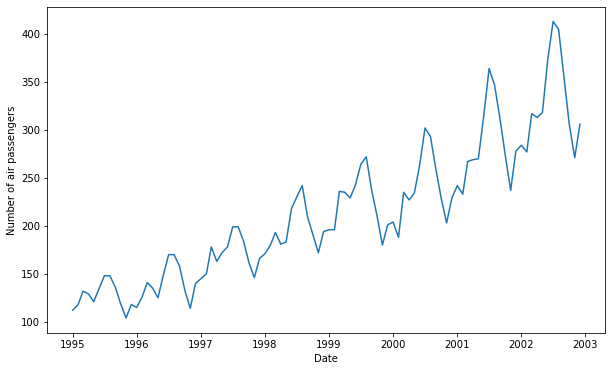

In [3]:
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.plot(indexedDataset)

In [4]:
#Determine rolling statistics
rolmean = indexedDataset.rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = indexedDataset.rolling(window=12).std()
print(rolmean,rolstd)

            Passengers
Month                 
1995-01-01         NaN
1995-02-01         NaN
1995-03-01         NaN
1995-04-01         NaN
1995-05-01         NaN
...                ...
2002-08-01  316.833333
2002-09-01  320.416667
2002-10-01  323.083333
2002-11-01  325.916667
2002-12-01  328.250000

[96 rows x 1 columns]             Passengers
Month                 
1995-01-01         NaN
1995-02-01         NaN
1995-03-01         NaN
1995-04-01         NaN
1995-05-01         NaN
...                ...
2002-08-01   54.530781
2002-09-01   55.586883
2002-10-01   53.899668
2002-11-01   49.692616
2002-12-01   47.861780

[96 rows x 1 columns]


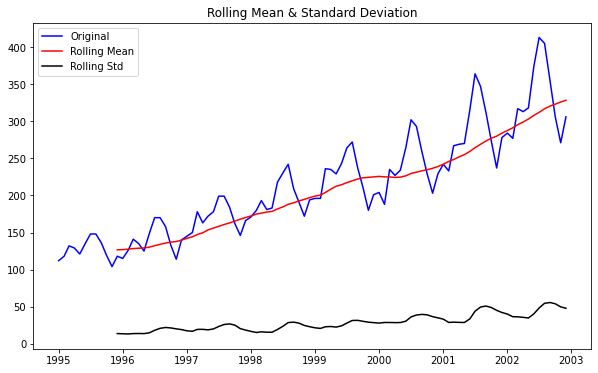

In [5]:
#Plot rolling statistics
orig = plt.plot(indexedDataset, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

From the above graph, we see that rolling mean itself has a trend component even though rolling standard deviation is fairly constant with time. For our time series to be stationary, we need to ensure that both the rolling statistics ie: mean & std. dev. remain time invariant or constant with time. Thus the curves for both of them have to be parallel to the x-axis, which in our case is not so.

To further augment our hypothesis that the time series is not stationary, let us perform the ADCF test.

In [6]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(indexedDataset['Passengers'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                  1.340248
p-value                         0.996825
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


For a Time series to be stationary, its ADCF test should have:

1.p-value to be low (according to the null hypothesis)
2.The critical values at 1%,5%,10% confidence intervals should be as close as possible to the Test Statistics
From the above ADCF test result, we see that p-value(at max can be 1.0) is very large. Also critical values are no where close to the Test Statistics. Hence, we can safely say that our Time Series at the moment is not stationary

# Data Transformation to achieve Stationarity

There are a couple of ways to achieve stationarity through data transformation like taking  𝑙𝑜𝑔10 , 𝑙𝑜𝑔𝑒 , square, square root, cube, cube root, exponential decay, time shift and so on ...

In our notebook, lets start of with log transformations. Our objective is to remove the trend component. Hence, flatter curves( ie: paralle to x-axis) for time series and rolling mean after taking log would say that our data transformation did a good job.

# Log Scale Transformation

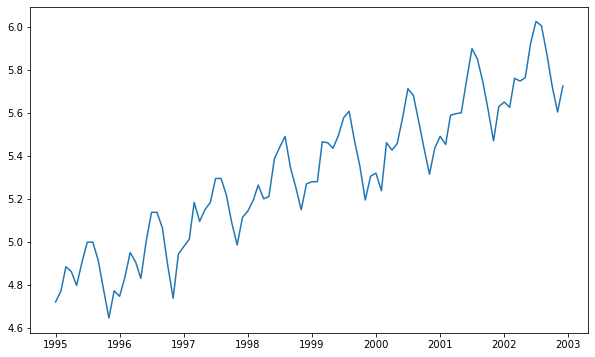

In [7]:
#Estimating trend
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

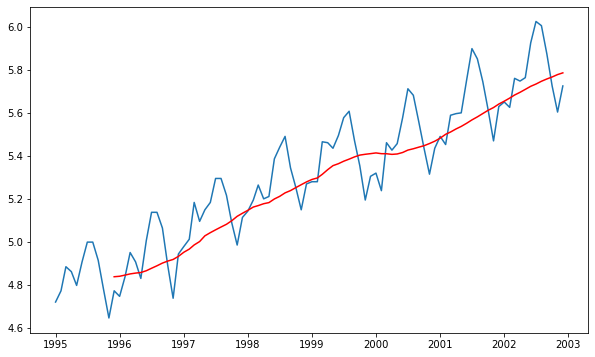

In [8]:
#The below transformation is required to make series stationary
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

From above graph, we see that even though rolling mean is not stationary, it is still better than the previous case, where no transfromation were applied to series. So we can atleast say that we are heading in the right direction.

We know from above graph that both the Time series with log scale as well as its moving average have a trend component. Thus we can apply a elementary intuition: subtraction one from the other should remove the trend component of both. Its like:

𝑙𝑜𝑔𝑠𝑐𝑎𝑙𝑒𝐿=𝑠𝑡𝑎𝑡𝑖𝑜𝑛𝑎𝑟𝑦𝑝𝑎𝑟𝑡(𝐿1)+𝑡𝑟𝑒𝑛𝑑(𝐿𝑇) 
𝑚𝑜𝑣𝑖𝑛𝑔𝑎𝑣𝑔𝑜𝑓𝑙𝑜𝑔𝑠𝑐𝑎𝑙𝑒𝐴=𝑠𝑡𝑎𝑡𝑖𝑜𝑛𝑎𝑟𝑦𝑝𝑎𝑟𝑡(𝐴1)+𝑡𝑟𝑒𝑛𝑑(𝐴𝑇) 
𝑟𝑒𝑠𝑢𝑙𝑡𝑠𝑒𝑟𝑖𝑒𝑠𝑅=𝐿−𝐴=(𝐿1+𝐿𝑇)−(𝐴1+𝐴𝑇)=(𝐿1−𝐴1)+(𝐿𝑇−𝐴𝑇) 
Since, L & A are series & it moving avg, their trend will be more or less same, Hence
LT-AT nearly equals to 0

Thus trend component will be almost removed. And we have,

𝑅=𝐿1−𝐴1 , our final non-trend curve

In [9]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,Passengers
Month,
1995-12-01,-0.065494
1996-01-01,-0.093449
1996-02-01,-0.007566
1996-03-01,0.099416
1996-04-01,0.052142
1996-05-01,-0.027529
1996-06-01,0.139881
1996-07-01,0.260184
1996-08-01,0.248635


In [10]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(dataset['Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    

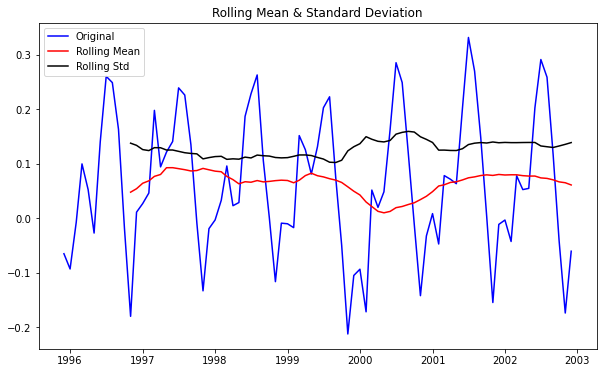

Results of Dickey Fuller Test:
Test Statistic                  1.340248
p-value                         0.996825
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [11]:
test_stationarity(datasetLogScaleMinusMovingAverage)

From above graph, we observe that our intuition that *"subtracting two related series having similar trend components will make the result stationary"* is true. We find that:

1.p-value has reduced from 0.99 to 0.022.
2.The critical values at 1%,5%,10% confidence intervals are pretty close to the Test Statistic. Thus, from above 2 points, we can say that our given series is stationary.
But, in the spirit of getting higher accuracy, let us explore & try to find a better scale than our current log.

Let us try out Exponential decay.


# Exponential Decay Transformation 

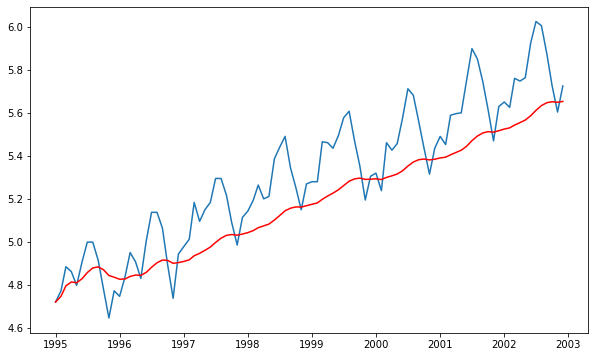

In [12]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

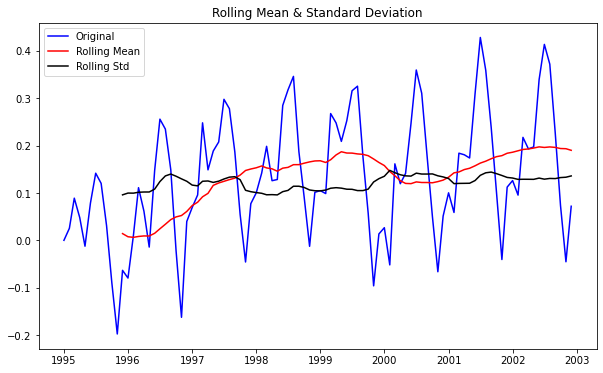

Results of Dickey Fuller Test:
Test Statistic                  1.340248
p-value                         0.996825
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [13]:
datasetLogScaleMinusExponentialMovingAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)

We observe that the Time Series is stationary & also the series for moving avg & std. dev. is almost parallel to x-axis thus they also have no trend.
Also,

p-value has decreased from 0.022 to 0.005.
Test Statistic value is very much closer to the Critical values.
Both the points say that our current transformation is better than the previous logarithmic transformation. Even though, we couldn't observe any differences by visually looking at the graphs, the tests confirmed decay to be much better.
But lets try one more time & find if an even better solution exists. We will try out the simple time shift technique, which is simply:

Given a set of observation on the time series:
𝑥0,𝑥1,𝑥2,𝑥3,....𝑥𝑛 

The shifted values will be:
𝑛𝑢𝑙𝑙,𝑥0,𝑥1,𝑥2,....𝑥𝑛  <---- basically all xi's shifted by 1 pos to right

Thus, the time series with time shifted values are:
𝑛𝑢𝑙𝑙,(𝑥1−𝑥0),(𝑥2−𝑥1),(𝑥3−𝑥2),(𝑥4−𝑥3),....(𝑥𝑛−𝑥𝑛−1)

# Time Shift Transformation

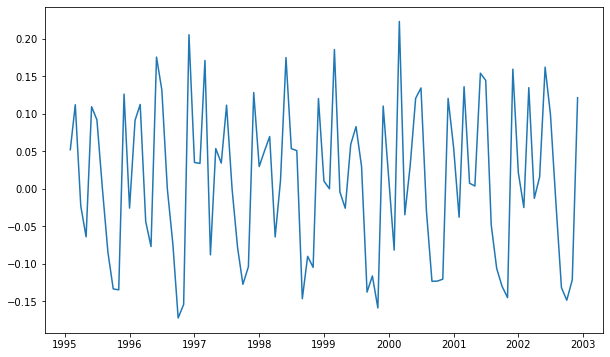

In [14]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

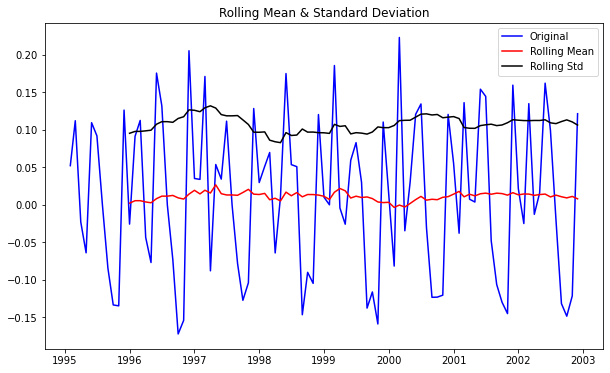

Results of Dickey Fuller Test:
Test Statistic                  1.340248
p-value                         0.996825
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [15]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

From above 2 graphs, we can see that, visually this is the best result as our series along with rolling statistic values of moving avg & moving std. dev. is very much flat & stationary. But, the ADCF test shows us that:

p-value of 0.07 is not as good as 0.005 of exponential decay.
Test Statistic value not as close to the critical values as that for exponential decay.
We have thus tried out 3 different transformation: log, exp decay & time shift. For simplicity, we will go with the log scale. The reason for doing this is that we can revert back to the original scale during forecasting.

Let us now break down the 3 components of the log scale series using a system libary function. Once, we separate our the components, we can simply ignore trend & seasonality and check on the nature of the residual part.

<ipython-input-16-85c9b430f966>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(411)
<ipython-input-16-85c9b430f966>:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(411)


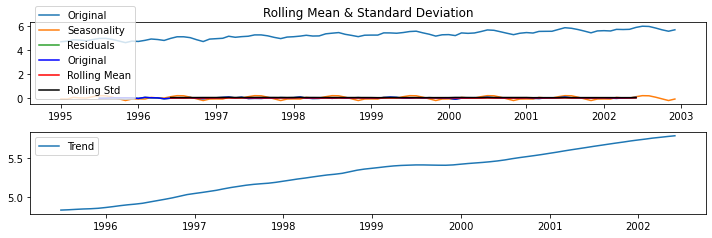

Results of Dickey Fuller Test:
Test Statistic                  1.340248
p-value                         0.996825
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [16]:
decomposition = seasonal_decompose(indexedDataset_logScale) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

#there can be cases where an observation simply consisted of trend & seasonality. In that case, there won't be 
#any residual component & that would be a null or NaN. Hence, we also remove such cases.
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

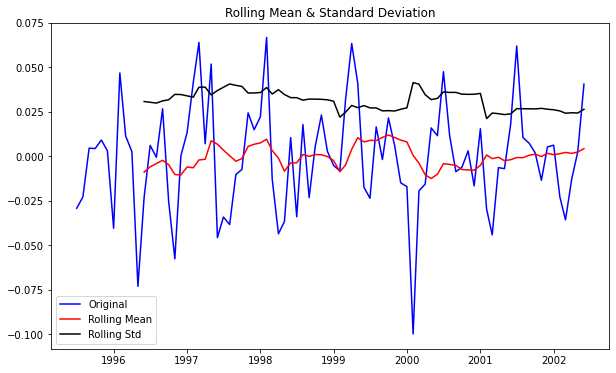

Results of Dickey Fuller Test:
Test Statistic                  1.340248
p-value                         0.996825
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [17]:
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

# Plotting ACF & PACF

/home/gargi/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


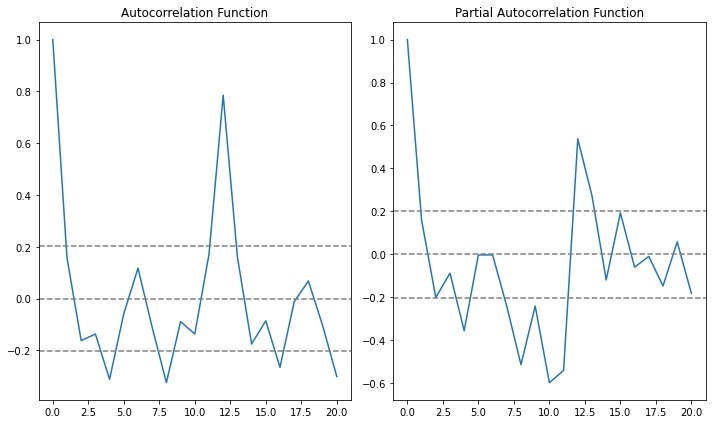

In [18]:
#ACF & PACF plots

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()            

From the ACF graph, we see that curve touches y=0.0 line at x=2. Thus, from theory, Q = 2 From the PACF graph, we see that curve touches y=0.0 line at x=2. Thus, from theory, P = 2

ARIMA is AR + I + MA. Before, we see an ARIMA model, let us check the results of the individual AR & MA model. Note that, these models will give a value of RSS. Lower RSS values indicate a better model.

# Building Models 

/home/gargi/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/gargi/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred f

Plotting AR model


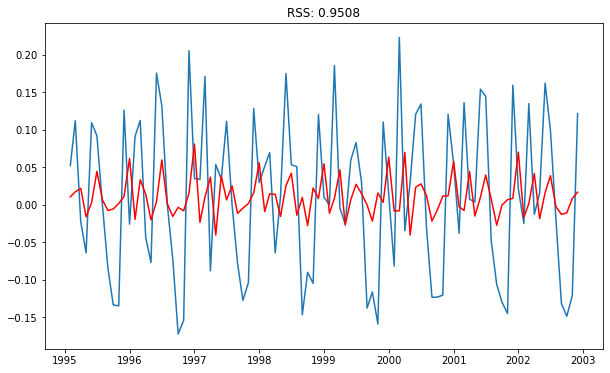

In [19]:
#AR Model
#making order=(2,1,0) gives RSS=1.5023
model = ARIMA(indexedDataset_logScale, order=(2,1,0))
results_AR = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting['Passengers'])**2))
print('Plotting AR model')

/home/gargi/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/gargi/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Plotting MA model


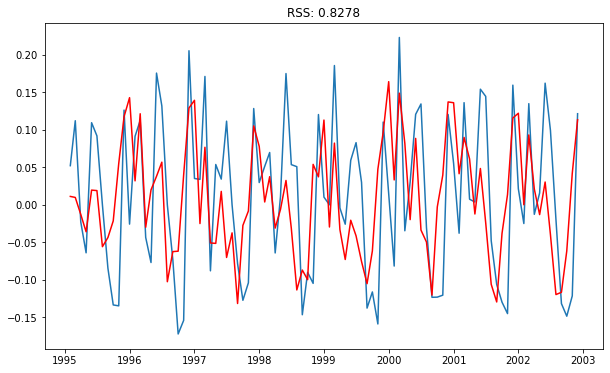

In [20]:
#MA Model
model = ARIMA(indexedDataset_logScale, order=(0,1,2))
results_MA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - datasetLogDiffShifting['Passengers'])**2))
print('Plotting MA model')

/home/gargi/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/gargi/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/gargi/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
remov

Plotting ARIMA model


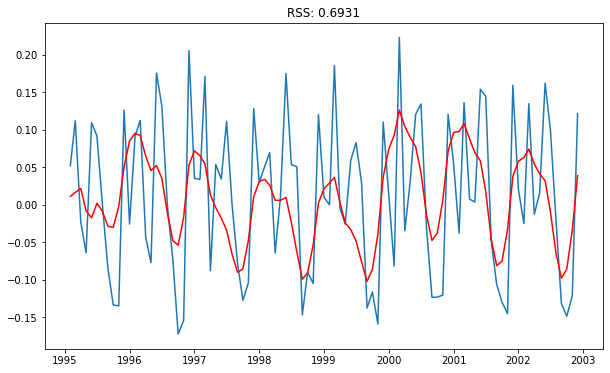

In [21]:
# AR+I+MA = ARIMA model
model = ARIMA(indexedDataset_logScale, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - datasetLogDiffShifting['Passengers'])**2))
print('Plotting ARIMA model')

By combining AR & MA into ARIMA, we see that RSS value has decreased from either case , indicating ARIMA to be better than its individual component models.

With the ARIMA model built, we will now generate predictions. But, before we do any plots for predictions ,we need to reconvert the predictions back to original form. This is because, our model was built on log transformed data.

# Prediction & Reverse transformations

In [22]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1995-02-01    0.011261
1995-03-01    0.016603
1995-04-01    0.021664
1995-05-01   -0.008096
1995-06-01   -0.017396
dtype: float64


In [23]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

Month
1995-02-01    0.011261
1995-03-01    0.027864
1995-04-01    0.049528
1995-05-01    0.041432
1995-06-01    0.024036
                ...   
2002-08-01    0.954060
2002-09-01    0.856192
2002-10-01    0.770510
2002-11-01    0.736546
2002-12-01    0.775400
Length: 95, dtype: float64


In [24]:
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['Passengers'].iloc[0], index=indexedDataset_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Month
1995-01-01    4.718499
1995-02-01    4.729760
1995-03-01    4.746363
1995-04-01    4.768027
1995-05-01    4.759931
dtype: float64

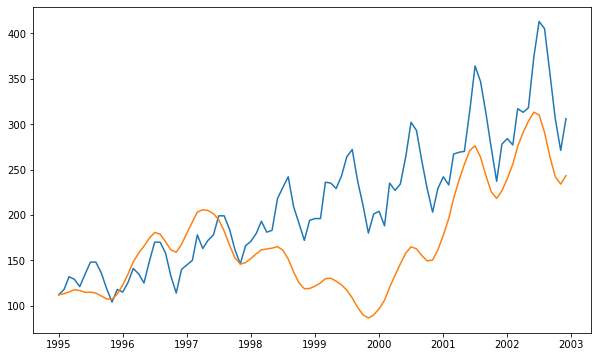

In [25]:
# Inverse of log is exp.
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)

We see that our predicted forecasts are very close to the real time series values indicating a fairly accurate model.

In [26]:
indexedDataset_logScale

,Passengers
Month,
1995-01-01,4.718499
1995-02-01,4.770685
1995-03-01,4.882802
1995-04-01,4.859812
1995-05-01,4.795791
...,...
2002-08-01,6.003887
2002-09-01,5.872118
2002-10-01,5.723585


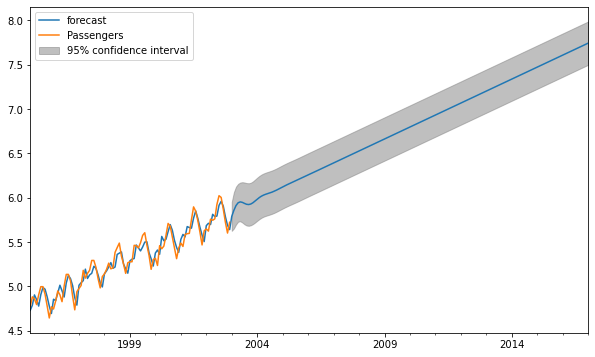

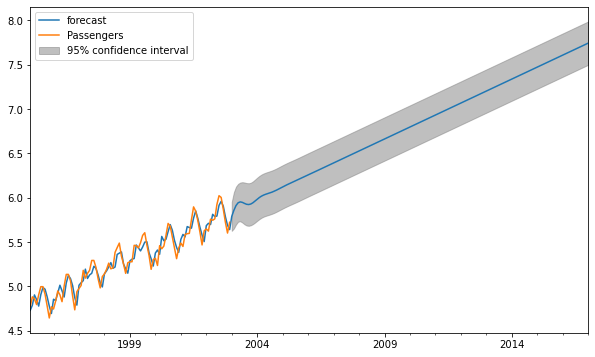

In [27]:
results_ARIMA.plot_predict(1,264) 